## Purpose:
#### 1. Predict conversion rate： note conversion_rate = mean(converted)
#### 2. Come up with recommendations for the product team and the marketing team to improve conversion rate

In [188]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

In [190]:
conversion_data = pd.read_csv('conversion_data.csv')
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
conversion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
conversion_data.shape

(316200, 6)

### I. Data Summary

In [5]:
conversion_data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [13]:
for column in conversion_data.columns:
    uniques = sorted(conversion_data[column].unique())
    print('{0:20s}{1:5d}\t'.format(column,len(uniques)),uniques[:5]) ## s = string, d = decimal integer, '\t' = space in strig

country                 4	 ['China', 'Germany', 'UK', 'US']
age                    60	 [17, 18, 19, 20, 21]
new_user                2	 [0, 1]
source                  3	 ['Ads', 'Direct', 'Seo']
total_pages_visited    29	 [1, 2, 3, 4, 5]
converted               2	 [0, 1]


In [33]:
conversion_data.groupby('country').count().reset_index()

,country,age,new_user,source,total_pages_visited,converted
0,China,76602,76602,76602,76602,76602
1,Germany,13056,13056,13056,13056,13056
2,UK,48450,48450,48450,48450,48450
3,US,178092,178092,178092,178092,178092


In [62]:
sorted(conversion_data['age'].unique(),reverse= True)[:10]

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67]

In [64]:
conversion_data[conversion_data['age'] > 80] ## only two observations have age > 80, therefore remove the rows

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


##### Findings: 
1. This may be a US site, because US has the most observations
2. 'age' has max '123' and '111', since only two observations has this problem, just remove the rows -> safest way
3. mean conversion rate at around 3% is industry stantdard, it make senses
4. user age is pretty young

### II. Data Cleaning: remove outliers 

In [65]:
conversion_data = conversion_data[conversion_data['age'] < 80]

### III. EDA: variables vs lable 

In [76]:
# data_types = conversion_data.dtypes  
# cat_cols = list(data_types[data_types == 'object'].index)
# con_cols = list(data_types[data_types == 'int64'].index)

i. country

Text(0.5,1,'conversion rate by country')

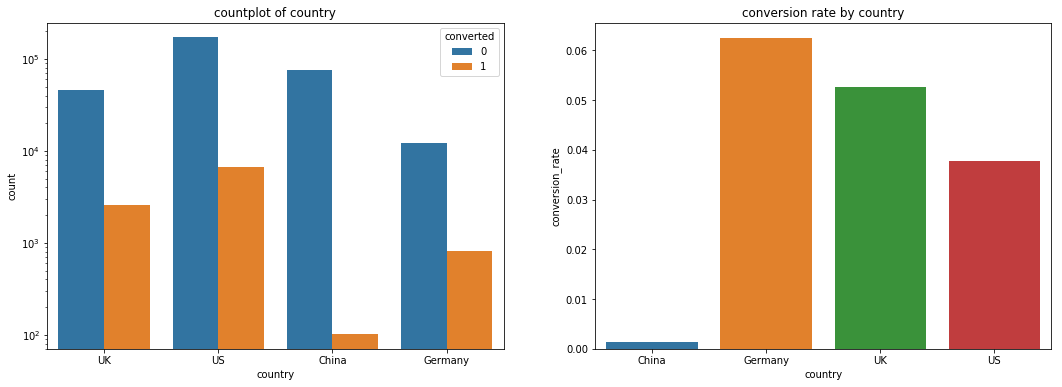

In [127]:
convertion_rate = conversion_data.groupby('country')['converted'].mean().reset_index()

fig, ax = plt.subplots(ncols = 2, nrows= 1, figsize = (18,6))

sns.countplot(x= 'country', hue = 'converted', data = conversion_data, ax = ax[0])
ax[0].set_title('countplot of country')
ax[0].set_yscale('log') ## since the number is very small, set scale to log 

sns.barplot(x ='country', y ='converted', data = convertion_rate,ax = ax[1]) 
ax[1].set_ylabel('conversion_rate')
ax[1].set_title('conversion rate by country')

ii. source

Text(0.5,1,'conversion rate by source')

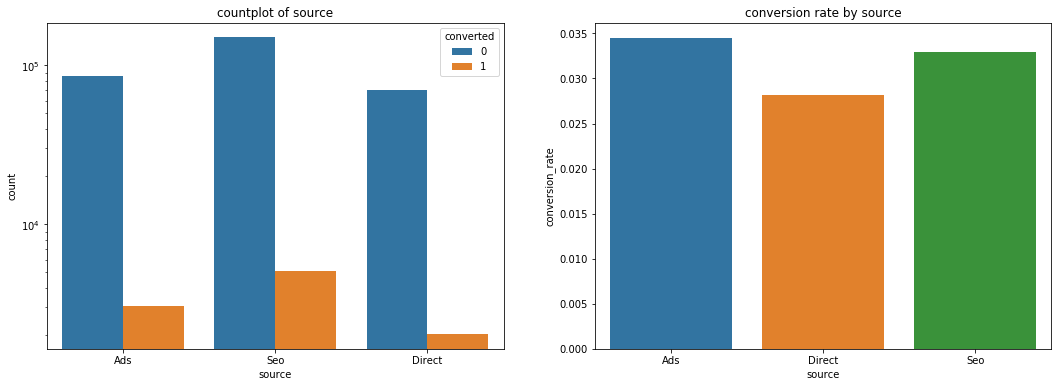

In [131]:
convertion_source = conversion_data.groupby('source')['converted'].mean().reset_index()

fig, ax = plt.subplots(ncols = 2, nrows= 1, figsize = (18,6))

sns.countplot(x= 'source', hue = 'converted', data = conversion_data, ax = ax[0])
ax[0].set_title('countplot of source')
ax[0].set_yscale('log') ## since the number is very small, set scale to log 

sns.barplot(x ='source', y ='converted', data = convertion_source,ax = ax[1]) 
ax[1].set_ylabel('conversion_rate')
ax[1].set_title('conversion rate by source')

iii. new user 

Text(0.5,1,'conversion rate by new_user')

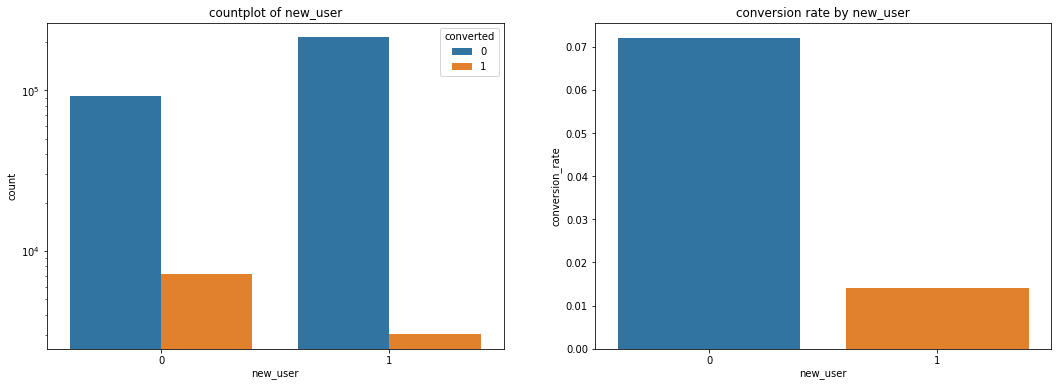

In [133]:
convertion_new_user = conversion_data.groupby('new_user')['converted'].mean().reset_index()

fig, ax = plt.subplots(ncols = 2, nrows= 1, figsize = (18,6))

sns.countplot(x= 'new_user', hue = 'converted', data = conversion_data, ax = ax[0])
ax[0].set_title('countplot of new_user')
ax[0].set_yscale('log') ## since the number is very small, set scale to log 

sns.barplot(x ='new_user', y ='converted', data = convertion_new_user,ax = ax[1]) 
ax[1].set_ylabel('conversion_rate')
ax[1].set_title('conversion rate by new_user')

vi. age

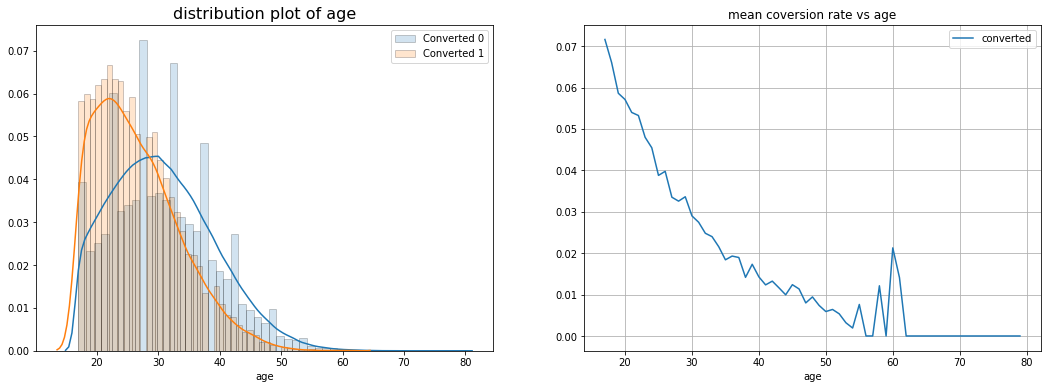

In [184]:
convertion_age = conversion_data.groupby('age')['converted'].mean().reset_index()

fig, ax = plt.subplots(ncols = 2, nrows= 1, figsize = (18,6))

sns.distplot(conversion_data[conversion_data['converted'] == 0]['age'], label='Converted 0', ax = ax[0], hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2})
sns.distplot(conversion_data[conversion_data['converted'] == 1]['age'], label='Converted 1',  ax = ax[0], hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2})
ax[0].set_title('distribution plot of age',fontsize=16)
ax[0].legend()

convertion_age.plot(x = 'age', y = 'converted',ax = ax[1],kind = 'line')
ax[1].set_title('mean coversion rate vs age')
ax[1].grid(True)

v. total_pages_visited

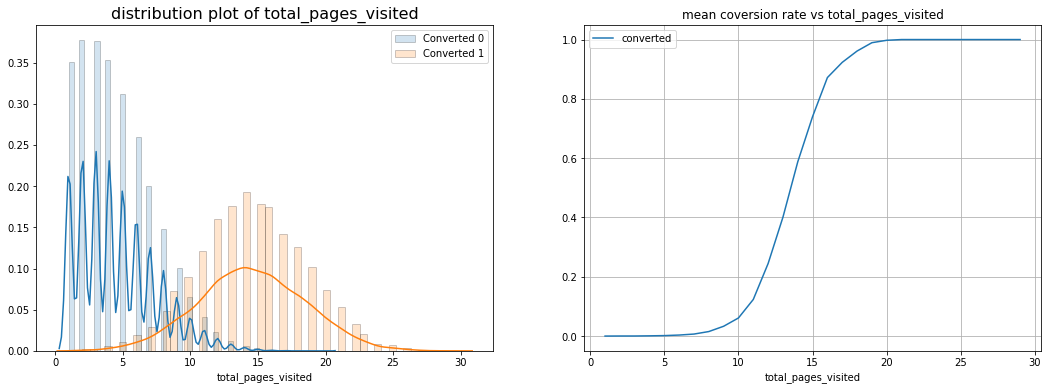

In [183]:
convertion_pv = conversion_data.groupby('total_pages_visited')['converted'].mean().reset_index()

fig, ax = plt.subplots(ncols = 2, nrows= 1, figsize = (18,6))

sns.distplot(conversion_data[conversion_data['converted'] == 0]['total_pages_visited'], label='Converted 0', ax = ax[0], hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2})
sns.distplot(conversion_data[conversion_data['converted'] == 1]['total_pages_visited'], label='Converted 1',  ax = ax[0], hist_kws = {'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2})
ax[0].set_title('distribution plot of total_pages_visited',fontsize=16)
ax[0].legend()

convertion_pv.plot(x = 'total_pages_visited', y = 'converted',ax = ax[1],kind = 'line')
ax[1].set_title('mean coversion rate vs total_pages_visited')
ax[1].grid(True)

iv. converted - label

Text(0.5,1,'countplot of label')

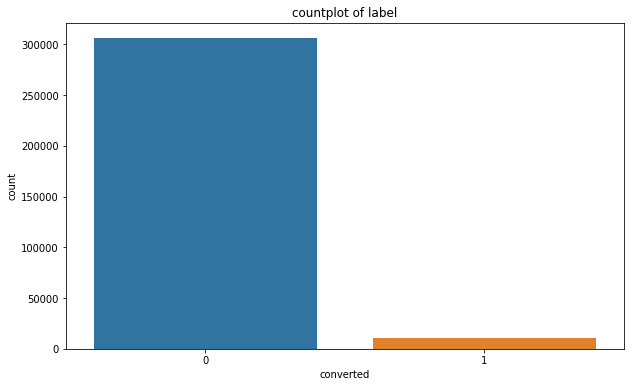

In [300]:
fig, ax = plt.subplots(1,1, figsize = (10,6))

sns.countplot(x= 'converted',data = conversion_data, ax = ax)
ax.set_title('countplot of label')
#ax[0].set_yscale('log') ## since the number is very small, set scale to log 

##### Finding: 
1. China has the lowest conversion rate than other countries 
2. Ads has the highest conversion rate, direct has the lowest
3. Returning users has a higher conversion rate 
4. Younger age has a higher conversion rate 
5. Convesion rate increases as total_pages_visted increases
6. Label - converted is highyly imbalance, should weight 

### VI. Machine Learning : Random Forest

In [189]:
## Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,23 hours 55 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_meierhabarexiti_g82r60
H2O cluster total nodes:,1
H2O cluster free memory:,745 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [191]:
## convert data to H2O frame and convert binary features to factor
## for binary classification, response should be a factor 
h2o_df = H2OFrame(conversion_data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.569857685009328,,,4.872966476913375,
maxs,,123.0,,,29.0,
sigma,,8.271801801807767,,,3.3411037579482046,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [195]:
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
train,test,valid = h2o_df.split_frame(ratios=([0.7,0.15]))

In [203]:
## specity predictors and response variable -> returns a list 
x = train.columns
y = "converted"
x.remove(y)

In [216]:
## Create RF hyperparameters for Grid Search
rf_params1 = {'max_depth': [15,20],'ntrees':[80,100], } # ntress = number of tress 

## Train and validate a cartesian grid of RF
rf_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_grid1',
                          hyper_params=rf_params1)

rf_grid1.train(x = x, y = y,
                training_frame = train,
                validation_frame = valid,
                balance_classes = True,
                mtries = -1, # number of features at each split, default -1 means automatically 
                score_each_iteration = True,
                nfolds = 3, 
                seed = 1)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [212]:
### Create RF model without grid search, but 3 fold cross validation activated 
# model = H2ORandomForestEstimator(balance_classes = True,ntrees=100, max_depth=20, 
#                                  mtries=-1, seed=42, score_each_iteration=True, nfolds = 3) 

In [257]:
rf_grid1.show()

    max_depth ntrees         model_ids               logloss
0          15     80  rf_grid1_model_0    0.0537538160334116
1          15    100  rf_grid1_model_2     0.053995981506221
2          20     80  rf_grid1_model_1    0.0563365294914244
3          20    100  rf_grid1_model_3  0.056483569691478795


In [258]:
# Get the grid results, sorted by validation AUC
fr_gridperf1 = rf_grid1.get_grid(sort_by = 'auc', decreasing = True)
fr_gridperf1

    max_depth ntrees         model_ids                 auc
0          15    100  rf_grid1_model_2  0.9773845360454023
1          15     80  rf_grid1_model_0    0.97728421497643
2          20    100  rf_grid1_model_3  0.9762666640992379
3          20     80  rf_grid1_model_1  0.9759033861884523


In [259]:
# Grab the top RF model, chosen by validation AUC
best_rf1 = fr_gridperf1.models[0]
best_rf1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_grid1_model_2


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11812645119151689
RMSE: 0.3436952882882116
LogLoss: 0.3772219137806897
Mean Per-Class Error: 0.03984981686681066
AUC: 0.9929906886753843
Gini: 0.9859813773507686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02989778558730104: 


,0,1,Error,Rate
0,202996.0,11122.0,0.0519,(11122.0/214118.0)
1,5966.0,208148.0,0.0279,(5966.0/214114.0)
Total,208962.0,219270.0,0.0399,(17088.0/428232.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0298978,0.9605708,376.0
max f2,0.0094895,0.9770621,388.0
max f0point5,0.0817459,0.9622904,353.0
max accuracy,0.0337314,0.9601501,374.0
max precision,0.9986640,1.0,0.0
max recall,0.0018956,1.0,394.0
max specificity,0.9986640,1.0,0.0
max absolute_mcc,0.0298978,0.9204597,376.0
max min_per_class_accuracy,0.0425341,0.9587330,370.0
max mean_per_class_accuracy,0.0337314,0.9601502,374.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.88 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100016,0.9848569,1.9990847,1.9990847,0.9995330,0.9909216,0.9995330,0.9909216,0.0199940,0.0199940,99.9084748,99.9084748
,2,0.0200008,0.9761353,1.9990845,1.9990846,0.9995329,0.9802738,0.9995330,0.9855983,0.0199894,0.0399834,99.9084530,99.9084639
,3,0.0300001,0.9686612,1.9972162,1.9984619,0.9985988,0.9723201,0.9992216,0.9811726,0.0199707,0.0599540,99.7216227,99.8461883
,4,0.0400017,0.9616076,1.9972169,1.9981506,0.9985991,0.9650758,0.9990660,0.9771479,0.0199753,0.0799294,99.7216881,99.8150596
,5,0.0500009,0.9547610,1.9976833,1.9980571,0.9988323,0.9581074,0.9990192,0.9733402,0.0199753,0.0999047,99.7683303,99.8057146
,6,0.1000019,0.9224662,1.9976835,1.9978703,0.9988324,0.9387371,0.9989258,0.9560386,0.0998860,0.1997908,99.7683521,99.7870334
,7,0.1500005,0.8798384,1.9960020,1.9972476,0.9979917,0.9030102,0.9986145,0.9383630,0.0997973,0.2995881,99.6002017,99.7247581
,8,0.2000014,0.8059585,1.9919857,1.9959321,0.9959836,0.8456998,0.9979567,0.9151970,0.0996011,0.3991892,99.1985728,99.5932102
,9,0.3000009,0.6151065,1.9849799,1.9922814,0.9924807,0.7190793,0.9961314,0.8498249,0.1984971,0.5976863,98.4979894,99.2281394
,10,0.4000005,0.3134391,1.9488775,1.9814305,0.9744296,0.4736387,0.9907060,0.7557789,0.1948868,0.7925731,94.8877462,98.1430475




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.01279944764062958
RMSE: 0.11313464385690875
LogLoss: 0.05138295218066476
Mean Per-Class Error: 0.08263931082610632
AUC: 0.9782137095015916
Gini: 0.9564274190031832
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35377288003577007: 


,0,1,Error,Rate
0,45593.0,273.0,0.006,(273.0/45866.0)
1,470.0,1072.0,0.3048,(470.0/1542.0)
Total,46063.0,1345.0,0.0157,(743.0/47408.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3537729,0.7426394,193.0
max f2,0.1738758,0.7516052,248.0
max f0point5,0.5387796,0.8042668,144.0
max accuracy,0.4572132,0.9846650,165.0
max precision,0.9943672,1.0,0.0
max recall,0.0001206,1.0,398.0
max specificity,0.9943672,1.0,0.0
max absolute_mcc,0.3537729,0.7364215,193.0
max min_per_class_accuracy,0.0114684,0.9159290,360.0
max mean_per_class_accuracy,0.0043205,0.9173607,374.0


Gains/Lift Table: Avg response rate:  3.25 %, avg score:  2.72 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100194,0.8394071,28.8027306,28.8027306,0.9368421,0.9111670,0.9368421,0.9111670,0.2885863,0.2885863,2780.2730562,2780.2730562
,2,0.0200177,0.6113512,26.3338861,27.5696091,0.8565401,0.7388092,0.8967334,0.8250789,0.2632944,0.5518807,2533.3886070,2656.9609077
,3,0.0300160,0.3058736,15.9559999,23.7011265,0.5189873,0.4600676,0.7709065,0.7034940,0.1595331,0.7114137,1495.5999934,2270.1126481
,4,0.0400354,0.1525168,7.1197761,19.5514208,0.2315789,0.2144125,0.6359326,0.5810948,0.0713359,0.7827497,611.9776094,1855.1420773
,5,0.0500548,0.0882451,3.5598880,16.3504186,0.1157895,0.1148566,0.5318163,0.4877686,0.0356680,0.8184176,255.9888047,1535.0418647
,6,0.1002784,0.0156941,1.6786155,9.0021722,0.0545989,0.0391902,0.2928061,0.2631020,0.0843061,0.9027237,67.8615455,800.2172244
,7,0.1500169,0.0046517,1.0952235,6.3806051,0.0356234,0.0088185,0.2075366,0.1787937,0.0544747,0.9571984,9.5223480,538.0605148
,8,0.2003248,0.0017843,0.3609416,4.8688754,0.0117400,0.0028070,0.1583658,0.1345978,0.0181582,0.9753567,-63.9058426,386.8875378
,9,0.3000759,0.0006925,0.1430279,3.2979114,0.0046521,0.0011062,0.1072684,0.0902226,0.0142672,0.9896239,-85.6972144,229.7911444
,10,0.4004387,0.0004116,0.0516931,2.4843049,0.0016814,0.0005285,0.0808049,0.0677424,0.0051881,0.9948119,-94.8306872,148.4304894




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.013342015695779169
RMSE: 0.11550764345176111
LogLoss: 0.053995981506221
Mean Per-Class Error: 0.08013408517176368
AUC: 0.9773845360454023
Gini: 0.9547690720908046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3810648104988288: 


,0,1,Error,Rate
0,212951.0,1167.0,0.0055,(1167.0/214118.0)
1,2431.0,4740.0,0.339,(2431.0/7171.0)
Total,215382.0,5907.0,0.0163,(3598.0/221289.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3810648,0.7248815,194.0
max f2,0.1379121,0.7335923,279.0
max f0point5,0.4892836,0.7906251,161.0
max accuracy,0.4858671,0.9840480,162.0
max precision,0.9885939,1.0,0.0
max recall,0.0000545,1.0,399.0
max specificity,0.9885939,1.0,0.0
max absolute_mcc,0.3810648,0.7201634,194.0
max min_per_class_accuracy,0.0097177,0.9154930,371.0
max mean_per_class_accuracy,0.0044710,0.9198659,380.0


Gains/Lift Table: Avg response rate:  3.24 %, avg score:  2.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100005,0.8330567,29.1716081,29.1716081,0.9453231,0.9080650,0.9453231,0.9080650,0.2917306,0.2917306,2817.1608067,2817.1608067
,2,0.0200055,0.6091497,25.4509068,27.3108372,0.8247516,0.7405239,0.8850237,0.8242755,0.2546367,0.5463673,2445.0906788,2631.0837199
,3,0.0300015,0.2954407,15.0248687,23.2173649,0.4868897,0.4381111,0.7523723,0.6956122,0.1501883,0.6965556,1402.4868663,2221.7364929
,4,0.0400020,0.1382045,7.0697922,19.1804717,0.2291008,0.2048061,0.6215545,0.5729107,0.0707014,0.7672570,606.9792204,1818.0471747
,5,0.0500206,0.0815900,3.7025084,16.0804045,0.1199820,0.1075906,0.5210949,0.4797122,0.0370939,0.8043509,270.2508355,1508.0404457
,6,0.1000005,0.0125485,1.9056612,8.9959153,0.0617541,0.0339319,0.2915179,0.2569127,0.0952447,0.8995956,90.5661151,799.5915281
,7,0.1500346,0.0032236,1.1928829,6.3937294,0.0386561,0.0066428,0.2071926,0.1734517,0.0596848,0.9592804,19.2882852,539.3729352
,8,0.2001365,0.0014142,0.3534840,4.8816222,0.0114549,0.0021064,0.1581918,0.1305573,0.0177102,0.9769907,-64.6515987,388.1622233
,9,0.3001279,0.0006701,0.1199378,3.2952066,0.0038867,0.0009224,0.1067831,0.0873678,0.0119927,0.9889834,-88.0062216,229.5206637
,10,0.4000199,0.0004271,0.0446724,2.4834911,0.0014476,0.0005266,0.0804790,0.0656821,0.0044624,0.9934458,-95.5327571,148.3491107



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.9830661,0.0006330,0.9842771,0.9821411,0.9827801
auc,0.9774955,0.0004721,0.9782994,0.9775225,0.9766647
err,0.0169339,0.0006330,0.0157229,0.0178589,0.0172199
err_count,1248.6666,41.09474,1169.0,1306.0,1271.0
f0point5,0.7496003,0.0158717,0.7808298,0.7290594,0.7389117
f1,0.7252293,0.0053445,0.7355802,0.7223639,0.7177438
f2,0.7029443,0.0064624,0.6952878,0.7157903,0.6977547
lift_top_group,29.102322,0.2253931,29.478481,28.699104,29.129381
logloss,0.0540034,0.0009789,0.0520504,0.0548602,0.0550996
max_per_class_error,0.3108993,0.0119184,0.3292079,0.2885260,0.3149640


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-09-23 19:04:09,29 min 58.560 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2018-09-23 19:04:10,29 min 59.109 sec,1.0,0.3216912,0.3705797,0.9907096,1.9907358,0.0448930,0.1157678,0.2063040,0.9359449,26.4733511,0.0156725
,2018-09-23 19:04:10,29 min 59.559 sec,2.0,0.3215966,0.3639380,0.9911722,1.9913111,0.0440384,0.1126623,0.1293764,0.9445871,28.8038057,0.0162631
,2018-09-23 19:04:11,30 min 0.449 sec,3.0,0.3413626,0.4006458,0.9896242,1.9911503,0.0498218,0.1169165,0.1044835,0.9498795,29.2862511,0.0173810
,2018-09-23 19:04:12,30 min 1.524 sec,4.0,0.3384398,0.3881506,0.9904489,1.9914919,0.0466504,0.1156979,0.0840609,0.9591762,29.7776799,0.0166849
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-09-23 19:06:51,32 min 40.692 sec,96.0,0.3444433,0.3784388,0.9929734,1.9990847,0.0399363,0.1132034,0.0514069,0.9783033,28.7380053,0.0156303
,2018-09-23 19:06:54,32 min 43.333 sec,97.0,0.3442218,0.3780669,0.9929785,1.9990847,0.0398149,0.1131766,0.0513898,0.9781490,28.7380053,0.0157146
,2018-09-23 19:06:56,32 min 45.739 sec,98.0,0.3439829,0.3776257,0.9929801,1.9990847,0.0398055,0.1131434,0.0513775,0.9781707,28.8027306,0.0162420
,2018-09-23 19:06:59,32 min 48.396 sec,99.0,0.3439391,0.3776752,0.9929861,1.9990847,0.0398639,0.1131486,0.0513759,0.9783633,28.8027306,0.0163475



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
total_pages_visited,5749481.0,1.0,0.7813267
new_user,708233.5625000,0.1231822,0.0962455
country,485335.3437500,0.0844138,0.0659547
age,349212.1250000,0.0607380,0.0474562
source,66351.2343750,0.0115404,0.0090168


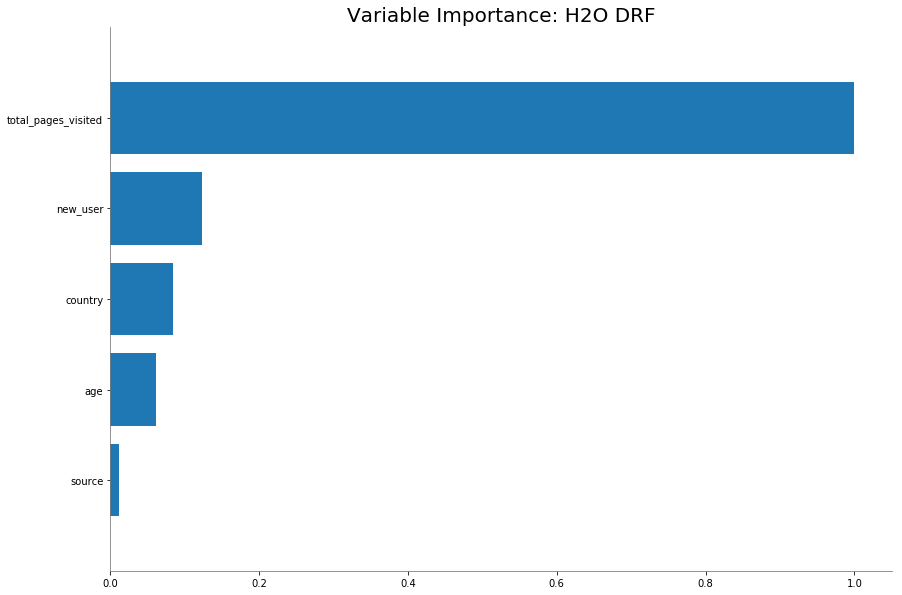

In [260]:
best_rf1.varimp_plot()

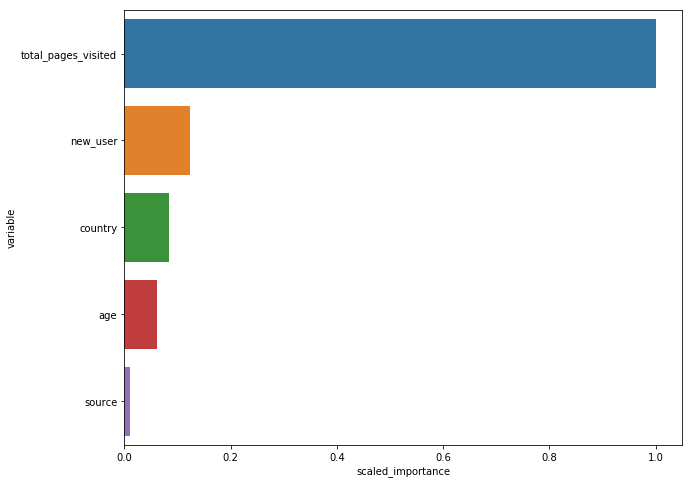

In [261]:
## or using Pandas: Feature importance
importance = best_rf1.varimp(use_pandas= True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)


In [262]:
importance

,variable,relative_importance,scaled_importance,percentage
0,total_pages_visited,5.749481e+06,1.000000,0.781327
1,new_user,7.082336e+05,0.123182,0.096246
2,country,4.853353e+05,0.084414,0.065955
3,age,3.492121e+05,0.060738,0.047456
4,source,6.635123e+04,0.011540,0.009017


In [286]:
## Make predictions on test data 
train_true = train.as_data_frame()['converted'].values
train_pred = best_rf1.predict(train).as_data_frame()['p1'].values # p1: probability of label == 1 -> converted
test_true = test.as_data_frame()['converted'].values
test_pred = best_rf1.predict(test).as_data_frame()['p1'].values 



drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [318]:
train_fpr, train_tpr, _ = roc_curve(train_true,train_pred) # true first, pred second, otherwise error 
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = auc(train_fpr,train_tpr)
test_auc = auc(test_fpr,test_tpr)

In [321]:
# Classification report : based on test data results 
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int))) # prob of converted > 0.5

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     46016
          1       0.85      0.64      0.73      1487

avg / total       0.98      0.99      0.98     47503



In [331]:
best_rf1_perf1= best_rf1.model_performance(test) # total error rate = 1.55%, good 
best_rf1_perf1


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.01209796858289844
RMSE: 0.1099907658983173
LogLoss: 0.048608612163322705
Mean Per-Class Error: 0.07960283455688755
AUC: 0.9783649270731131
Gini: 0.9567298541462261
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3474842447786453: 


,0,1,Error,Rate
0,45701.0,315.0,0.0068,(315.0/46016.0)
1,421.0,1066.0,0.2831,(421.0/1487.0)
Total,46122.0,1381.0,0.0155,(736.0/47503.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3474842,0.7433752,197.0
max f2,0.1260414,0.7522787,273.0
max f0point5,0.5230833,0.8060688,151.0
max accuracy,0.4641816,0.9856430,162.0
max precision,0.9932271,1.0,0.0
max recall,0.0001261,1.0,398.0
max specificity,0.9932271,1.0,0.0
max absolute_mcc,0.4565778,0.7409167,164.0
max min_per_class_accuracy,0.0126409,0.9188326,359.0
max mean_per_class_accuracy,0.0115003,0.9203972,361.0


Gains/Lift Table: Avg response rate:  3.13 %, avg score:  2.72 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100204,0.8386923,30.4690539,30.4690539,0.9537815,0.9136389,0.9537815,0.9136389,0.3053127,0.3053127,2946.9053930,2946.9053930
,2,0.0200198,0.6045781,26.4979747,28.4856022,0.8294737,0.7418499,0.8916930,0.8278347,0.2649630,0.5702757,2549.7974728,2748.5602173
,3,0.0300192,0.3137094,15.7373759,24.2391733,0.4926316,0.4568396,0.7587658,0.7042564,0.1573638,0.7276395,1473.7375854,2323.9173350
,4,0.0400396,0.1508318,6.0401208,19.6846260,0.1890756,0.2148828,0.6161935,0.5817843,0.0605245,0.7881641,504.0120823,1868.4626030
,5,0.0502495,0.0875961,4.2813594,16.5549300,0.1340206,0.1140285,0.5182237,0.4867439,0.0437122,0.8318763,328.1359410,1555.4930047
,6,0.1000779,0.0153212,1.6330414,9.1253738,0.0511196,0.0385393,0.2856542,0.2635844,0.0813719,0.9132482,63.3041351,812.5373769
,7,0.1500326,0.0048451,0.8211872,6.3604187,0.0257059,0.0087794,0.1991020,0.1787447,0.0410222,0.9542703,-17.8812810,536.0418704
,8,0.2000295,0.0018185,0.3631702,4.8614222,0.0113684,0.0029008,0.1521785,0.1347930,0.0181574,0.9724277,-63.6829788,386.1422159
,9,0.3001284,0.0007201,0.1813942,3.3005375,0.0056782,0.0011376,0.1033177,0.0902162,0.0181574,0.9905851,-81.8605835,230.0537463
,10,0.4007747,0.0004237,0.0267271,2.4783877,0.0008366,0.0005421,0.0775817,0.0676964,0.0026900,0.9932751,-97.3272932,147.8387684


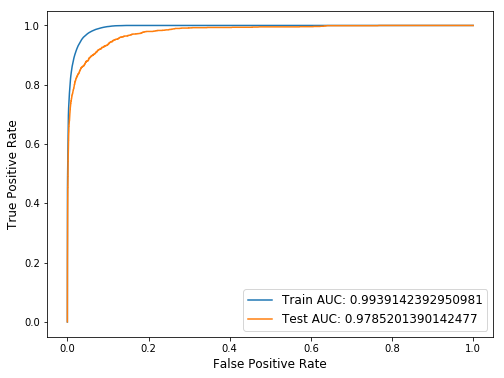

In [334]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


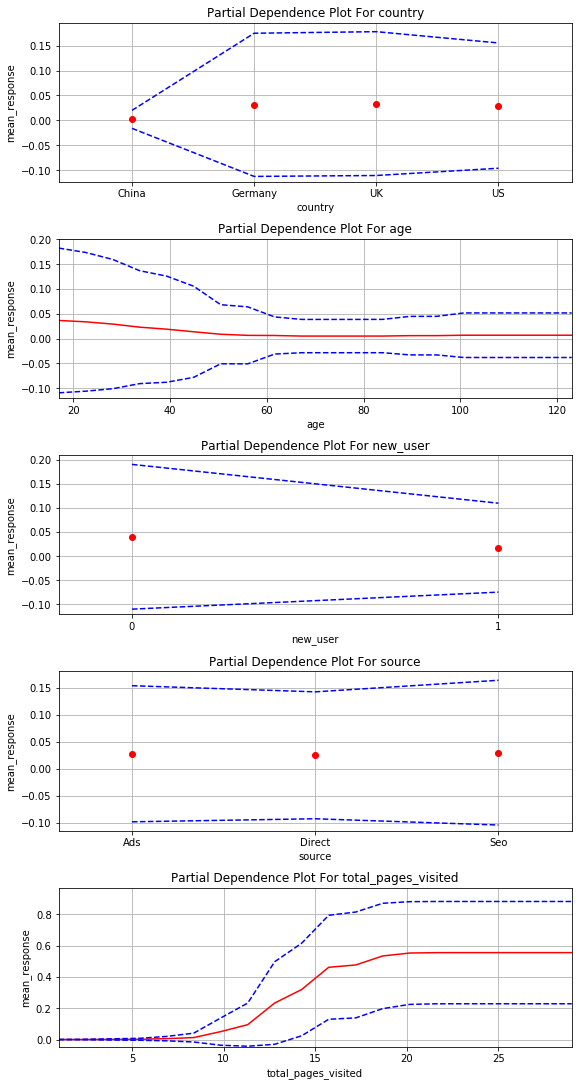

In [338]:
_ = best_rf1.partial_plot(train, cols=x, figsize=(8, 15))

In [339]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_ab8c closed.


### Conclusions:
1. The site works well for young users. Use marketing chanels that reaches young users
2. The site is working very well for Germany for conversion. However, less German users compared to other countries.Reach out to Germans 
3. Users with old account do much better. Send old users emails and provide discount to bring them back 
4. Something wrong with Chinese version of the site. Maybe translation has some problem. Fix it big opportunity.
5. Maybe go through UI and figure out why older users perfomrs so badly?
6. If a person have visited many pages, has high purchase intent. Those are probabyly the easest users to make convert.

### GridSearch in H2O python example
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html

### Modeling Process Summary

1. train/validation/test split using split_frame(ratios=([0.7,0.15]))

2. specify a list containing variables and a list for label 

3. If GirdSearch and crossvalidation needed:
    i. create a dictionary for possible values of paramaters for the model
    ii. initiate GridSearch, pass the model to be used to the girdsearch function
    iii. train the grid search model by defining x, y, training_frame, validation_frame and paramaters of choice
    vi. predict on test data
    NOTE: no need to rerun the best model on training data
    
4. If only want crossvalidation with a validation set wituhout gridsearch for all possible params:
    i: create a model with paramaters passing into the model 
    ii. train the model with paramaters x, y, training_frame, validation_frame
    iii predict on test_x
    
